# Demographic summaries of NEU Twitter Panel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

from definitions import DEMOG_FILE, DEMOG_SCHEMA, WEIGHTS_FILE, WEIGHTS_SCHEMA, \
                        WRU_IMPUTATIONS_FILE, URBAN_CODES_FILE, ZILLOW_FILE, \
                        PARTY_CODINGS, FIPS_MAPPING_FILE

pd.set_option('display.float_format', '{:.3f}'.format)

REGISTERED_VOTERS_ONLY = True

This notebook provides an overview of the demographics for the users comprising the Twitter panel. It mostly analyzes a file of user demographics I generated [here](https://github.com/sdmccabe/twitter-panel-summaries/demog/extract_demographics.py). This file is **sensitive** and should not be shared widely.

Note: all paths are on the assumption the notebook is started in the `notebooks/` folder of the repository.

In [2]:
df = pd.read_csv(DEMOG_FILE,
                 header=None,
                 sep='\t', 
                 names=list(DEMOG_SCHEMA.keys()),
                 dtype=DEMOG_SCHEMA,
                )


In [3]:
weights = pd.read_csv(WEIGHTS_FILE,
                      sep=",",
                      names=list(WEIGHTS_SCHEMA.keys()),
                      dtype=WEIGHTS_SCHEMA,
                      quotechar='"',
                      header=0)
df = df.merge(weights, how='left', on='id')
df = df[pd.notnull(df['weight'])]
df.drop(columns=['id', 'state', 'first_tweet', 'last_tweet', 'user_created_at']).head()

,num_tweets,age,gender,race,party,cd,zip,county_fips,partisan_score,registration_status,statuses_count,favourites_count,followers_count,friends_count,verified,weight
0,19,46.000,Male,Native American,Democrat,1.000,57642,31,90.700,1.000,19.000,0.000,1.000,75.000,False,1.445
1,4,27.000,Male,Caucasian,Unaffiliated,4.000,48642,111,46.900,1.000,4.000,0.000,2.000,7.000,False,0.499
2,430,45.000,Male,Caucasian,Unaffiliated,1.000,75605,203,5.700,1.000,430.000,1.000,80.000,50.000,False,0.509
4,623,25.000,Female,African-American,Unaffiliated,5.000,35611,83,92.800,1.000,628.000,3.000,403.000,927.000,False,1.266
5,3129,26.000,Female,Caucasian,Republican,16.000,17603,71,17.800,1.000,5672.000,54.000,134.000,160.000,False,0.449


In [4]:
if REGISTERED_VOTERS_ONLY:
    df = df[df['registration_status'] == 1.]
print(df.shape)

(1496433, 21)


In [5]:
# "active" corresponds to having a tweet after 2019-09-01
df['active'] = df['last_tweet'] > 1567296000

In [6]:
# TODO: handle the NAs in age
#df.age.fillna(-1, inplace=True)

In [7]:
def weighted_histogram(df, var, weight_var="weight", normalize=True):
    df = df[(pd.notnull(df[var])) & (pd.notnull(df[weight_var]))]
    hist = (df.groupby(var)
                    .agg({'id': 'count', weight_var: 'sum'})
                    .rename({'id': 'unweighted', weight_var: 'weighted'}, axis=1)
                    .reset_index())
    if normalize:
        hist['unweighted'] /= df.shape[0]
        hist['weighted'] /= df[weight_var].sum()
    return hist

In [8]:
# https://stackoverflow.com/questions/26102867/python-weighted-median-algorithm-with-pandas
  
def weighted_quantile(df, val, weight, quantile):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() * quantile
    df = df_sorted[cumsum >= cutoff]
    return df[val].iloc[0]

def weighted_median(df, val, weight='weight'):
    return weighted_quantile(df, val, weight, 0.5)

## Voter Registration

In [9]:
df['registration_status'].value_counts(normalize=True)

1.000   1.000
Name: registration_status, dtype: float64

## Age

Throughout this notebook, there are two ways to consider the demographic composition of the panel. This first is to simply examine the number of panel members of category X:

In [10]:
df['age'].value_counts().head(3)

20.000    53411
21.000    52553
22.000    49974
Name: age, dtype: int64

In [11]:
age_histogram = weighted_histogram(df, 'age', normalize=False)
age_histogram.head(8)

,age,unweighted,weighted
0,16.000,15,6.319
1,17.000,582,229.914
2,18.000,12638,5465.467
3,19.000,48921,20350.942
4,20.000,53411,22198.883
5,21.000,52553,22135.136
6,22.000,49974,21319.822
7,23.000,49338,29087.344


In [12]:
print(np.median(df[pd.notnull(df.age)].age))
print(weighted_median(df, 'age', 'weight'))

36.0
49.0


In this case, the two measures do disagree slightly. This is more apparent when visualizing the data.

Text(0, 0.5, 'Thousands of users')

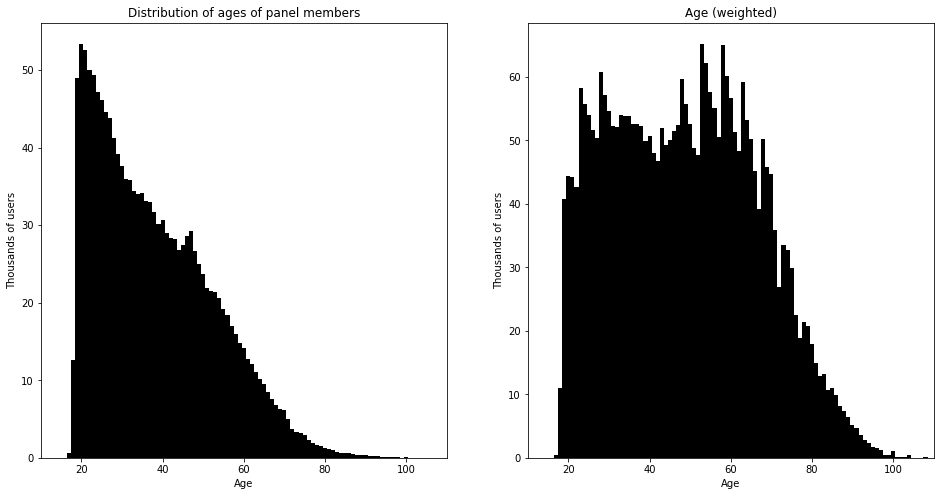

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2, gridspec_kw={'width_ratios':[0.9, 0.9]})

#ax1.hist(df['age'], bins = list(range(115)), color = 'black')
ax1.bar(age_histogram['age'], age_histogram['unweighted'], width=1, color='black')
ax1.set_xlim(10, 110)

ax1.set_yticks([0, 10000, 20000, 30000, 40000, 50000])
ax1.set_yticklabels(["0", "10", "20", "30", "40", "50"])
ax1.set_ylabel("Thousands of users")

ax1.set_xlabel("Age")
ax1.set_xticks([20, 40, 60, 80, 100])
ax1.set_title("Distribution of ages of panel members")

ax2.bar(age_histogram['age'], age_histogram['weighted'], width=1, color='black')
ax2.set_xlim(10, 110)
ax2.set_xlabel("Age")
ax2.set_xticks([20, 40, 60, 80, 100])
ax2.set_title("Age (weighted)")
ax2.set_yticklabels(["0", "10", "20", "30", "40", "50", "60", "70"])
ax2.set_ylabel("Thousands of users")

#fig.savefig("../figs/age.pdf", bbox_inches='tight')
#fig.savefig("../figs/age.png", bbox_inches='tight')

Finally, note that there is some missingness in age, representing around 6-7% of both members and total tweets.

In [14]:
print(100 * df.age.isna().sum()/len(df.age))
print(100 * df.fillna(-1).groupby('age').agg({"num_tweets": 'sum'}).iloc[0]/df.num_tweets.sum())

0.8573053387622432
num_tweets   0.949
Name: -1.0, dtype: float64


### Binned ages

In [15]:
# NOTE/TODO: pandas's 'Int64' dtype is behaving very oddly (read: producing bizarre bins) with `pd.cut`, so I coerce to float here.
# see <https://github.com/pandas-dev/pandas/issues/30787> for more information
df['age_bin'] = pd.cut(df.age.astype(np.float64),
                       [0, 17, 29, 49, 64, np.inf],
                       labels=["<18", "18-29", "30-50", "50-65", "65+"],
                       right=True)
age_bins = weighted_histogram(df, 'age_bin')
age_bins.head()

,age_bin,unweighted,weighted
0,<18,0.000,0.000
1,18-29,0.357,0.184
2,30-50,0.418,0.336
3,50-65,0.172,0.269
4,65+,0.054,0.211


Text(0.5, 1.0, 'Weighted')

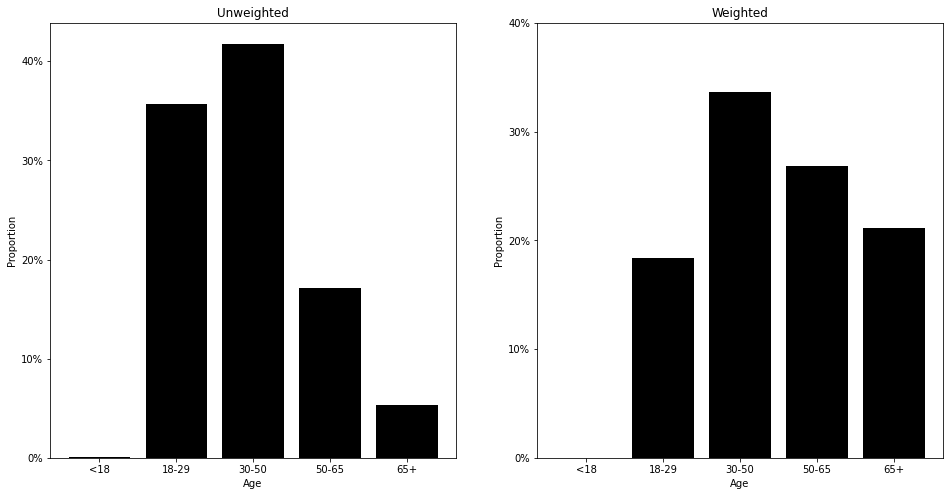

In [16]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2, gridspec_kw={'width_ratios':[0.9, 0.9]})
ax1.bar(age_bins['age_bin'], age_bins['unweighted'], color='black')
ax2.bar(age_bins['age_bin'], age_bins['weighted'], color='black')
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax1.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax2.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax1.set_xlabel("Age")
ax2.set_xlabel("Age")
ax1.set_ylabel("Proportion")
ax2.set_ylabel("Proportion")
ax1.set_title("Unweighted")
ax2.set_title("Weighted")

#fig.savefig("../figs/age_bin.pdf", bbox_inches='tight')
#fig.savefig("../figs/age_bin.png", bbox_inches='tight')

## Sex

For the more qualitative categories, there is considerably more missingness, and typically a few missing categories. Because we aren't doing means and standard deviations here, it's a little easier to incorporate the missingness directly.

In [17]:
df.loc[df['gender']=="Unknown", 'gender'] = np.nan
#df.gender.fillna("Unknown", inplace=True)
gender_histogram = weighted_histogram(df, 'gender')
gender_histogram.head()


,gender,unweighted,weighted
0,Female,0.559,0.534
1,Male,0.441,0.466


In [18]:
df.gender.value_counts()

Female    808073
Male      637763
Name: gender, dtype: int64

In both cases, males represent around 50% of the panel, females around 41%, and missing values around 9%.

Text(0.5, 1.0, 'Weighted')

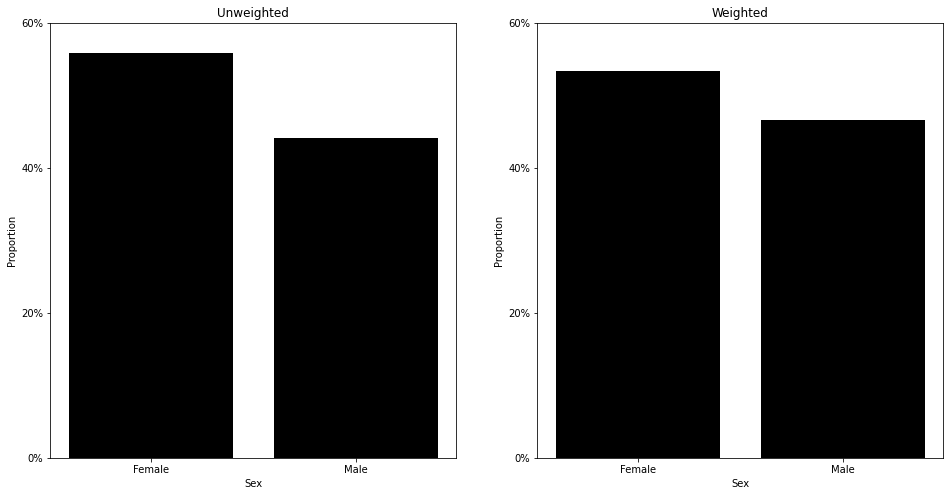

In [19]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
ax1.bar(gender_histogram['gender'], gender_histogram['unweighted'], color="black")
ax1.set_xlabel("Sex")
ax1.set_ylabel("Proportion")
ax1.set_yticks([0, 0.2, 0.4, 0.6])
ax1.set_yticklabels(["0%", "20%", "40%", "60%"])
ax1.set_title("Unweighted")

ax2.bar(gender_histogram['gender'], gender_histogram['weighted'], color="black")
ax2.set_xlabel("Sex")
ax2.set_ylabel("Proportion")
ax2.set_yticks([0, 0.2, 0.4, 0.6])
ax2.set_yticklabels(["0%", "20%", "40%", "60%"])
ax2.set_title("Weighted")

#fig.savefig("../figs/sex.pdf", bbox_inches='tight')
#fig.savefig("../figs/sex.png", bbox_inches='tight')

## Race

In [20]:
df.race.fillna("Uncoded", inplace=True)
wru = pd.read_csv(WRU_IMPUTATIONS_FILE,
                  sep='\t',
                  dtype={'id_str': 'str'}).rename({'id_str': 'id'}, axis=1)
wru['imputed_race'] = wru['imputed_race'].fillna('Other') # NOTE/TODO: could be "Uncoded"

df = df.merge(wru, how='left', on='id').drop(['pred.whi', 'pred.bla', 'pred.his', 'pred.asi', 'pred.oth'], axis=1)

def combine_race(ts, wru):
    if ts == "Uncoded": # NOTE/TODO: could be ['Uncoded', 'Other']
        return wru
    else:
        return ts

df['combined_race'] = df.apply(lambda x: combine_race(x['race'], x['imputed_race']), axis=1)

Without the imputations:

In [21]:
race_histogram = weighted_histogram(df[df.race!="Uncoded"], 'race')
race_histogram

,race,unweighted,weighted
0,African-American,0.076,0.120
1,Asian,0.020,0.019
2,Caucasian,0.851,0.796
3,Hispanic,0.047,0.059
4,Native American,0.002,0.002
5,Other,0.004,0.003


In [22]:
df[df.race!="Uncoded"].race.value_counts()

Caucasian           1242776
African-American     111495
Hispanic              67890
Asian                 28674
Other                  5339
Native American        3354
Name: race, dtype: int64

Pure-`wru` (no TargetSmart) race:

In [23]:
race_histogram = weighted_histogram(df, 'imputed_race')
race_histogram

,imputed_race,unweighted,weighted
0,African-American,0.070,0.092
1,Asian,0.027,0.025
2,Caucasian,0.837,0.811
3,Hispanic,0.062,0.069
4,Other,0.004,0.003


Combining TargetSmart and `wru`:

In [24]:
race_histogram = weighted_histogram(df, 'combined_race')
race_histogram

,combined_race,unweighted,weighted
0,African-American,0.076,0.118
1,Asian,0.025,0.025
2,Caucasian,0.839,0.785
3,Hispanic,0.054,0.067
4,Native American,0.002,0.002
5,Other,0.004,0.004


Whites make up the vast majority (~80%) of the panel, with Hispanics, African-Americans, and "Uncoded" making up most of the rest. 

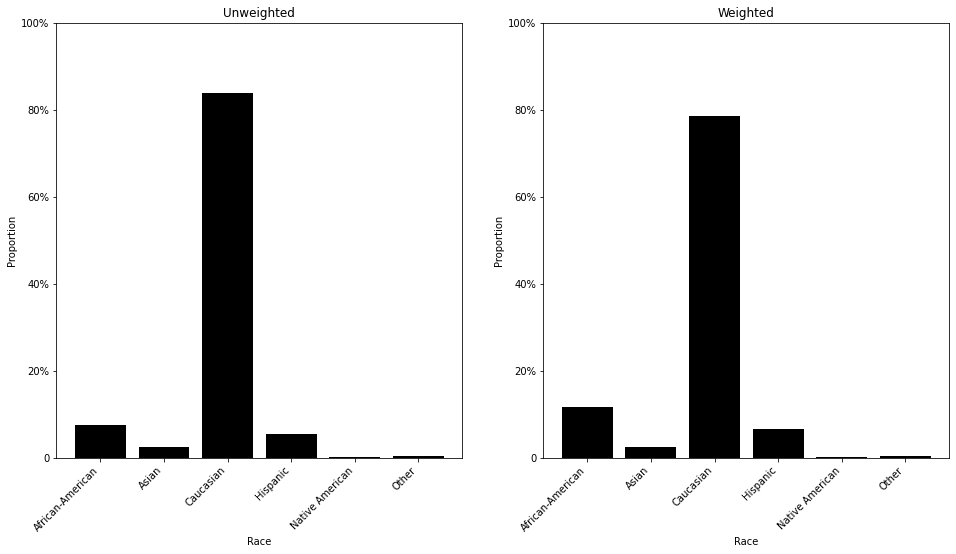

In [25]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)

ax1.bar(race_histogram['combined_race'], race_histogram['unweighted'], color="black")
ax1.set_xlabel("Race")
ax1.set_ylabel("Proportion")
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels(["0", "20%", "40%", "60%", "80%", "100%"])
ax1.set_title("Unweighted")

ax2.bar(race_histogram['combined_race'], race_histogram['weighted'], color="black")
ax2.set_xlabel("Race")
ax2.set_ylabel("Proportion")
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels(["0", "20%", "40%", "60%", "80%", "100%"])
ax2.set_title("Weighted")

for label in ax1.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
for label in ax2.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
#fig.savefig("../figs/race.pdf", bbox_inches='tight')
#fig.savefig("../figs/race.png", bbox_inches='tight')

## Party

In [26]:
df['short_party'] = df.party.replace(PARTY_CODINGS)
party_histogram = weighted_histogram(df[df.short_party!="Unknown/Other"], 'short_party')
party_histogram.head()

,short_party,unweighted,weighted
0,Democrat,0.249,0.237
1,Independent,0.600,0.612
2,Republican,0.151,0.151


Text(0.5, 1.0, 'Weighted')

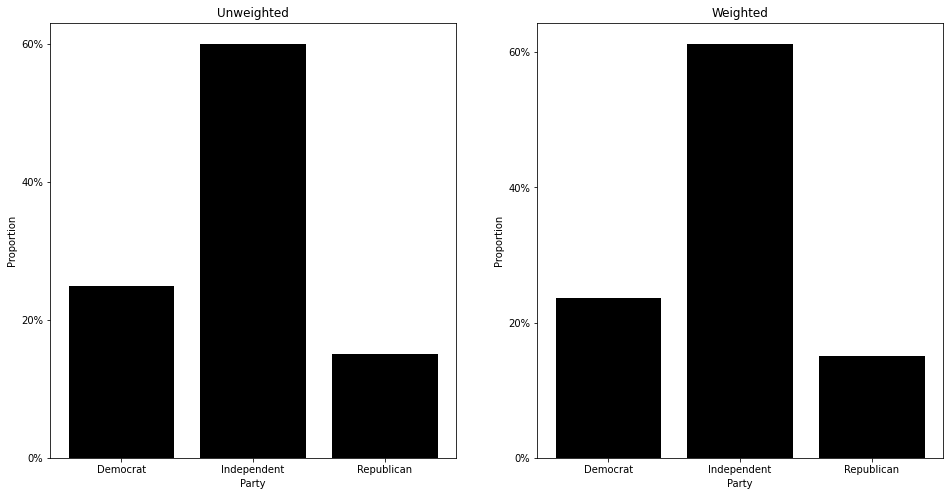

In [27]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
ax1.bar(party_histogram['short_party'], party_histogram['unweighted'], color="black")
ax1.set_xlabel("Party")
ax1.set_ylabel("Proportion")
ax1.set_yticks([0, 0.2, 0.4, 0.6])
ax1.set_yticklabels(["0%", "20%", "40%", "60%"])
ax1.set_title("Unweighted")

ax2.bar(party_histogram['short_party'], party_histogram['weighted'], color="black")
ax2.set_xlabel("Party")
ax2.set_ylabel("Proportion")
ax2.set_yticks([0, 0.2, 0.4, 0.6])
ax2.set_yticklabels(["0%", "20%", "40%", "60%"])
ax2.set_title("Weighted")

#fig.savefig("../figs/party.pdf", bbox_inches='tight')
#fig.savefig("../figs/party.png", bbox_inches='tight')

In [28]:
df['tsmart_party'] = pd.cut(df['partisan_score'].astype(np.float64), [0, 36, 65, 100], labels=["Republican", "Independent", "Democrat"])
party_histogram = weighted_histogram(df, 'tsmart_party')
party_histogram.head()

,tsmart_party,unweighted,weighted
0,Republican,0.343,0.357
1,Independent,0.129,0.112
2,Democrat,0.528,0.531


Text(0.5, 1.0, 'Weighted')

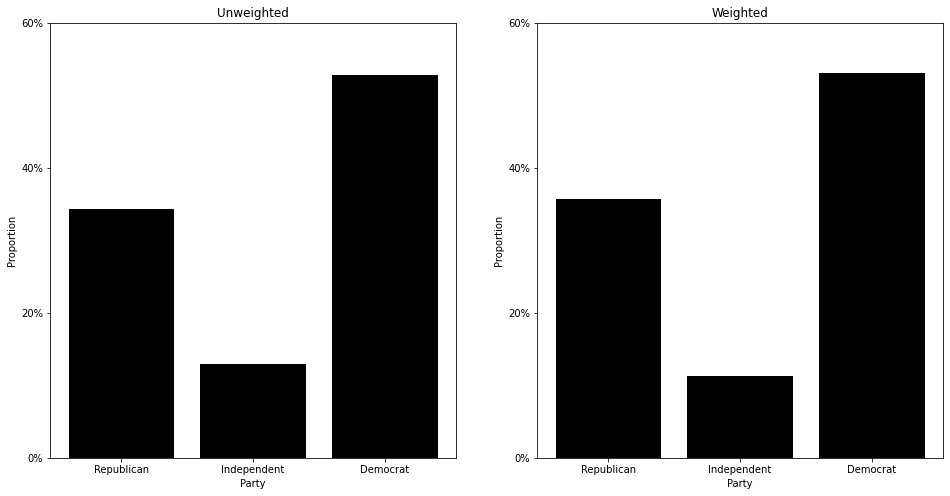

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
ax1.bar(party_histogram['tsmart_party'], party_histogram['unweighted'], color="black")
ax1.set_xlabel("Party")
ax1.set_ylabel("Proportion")
ax1.set_yticks([0, 0.2, 0.4, 0.6])
ax1.set_yticklabels(["0%", "20%", "40%", "60%"])
ax1.set_title("Unweighted")

ax2.bar(party_histogram['tsmart_party'], party_histogram['weighted'], color="black")
ax2.set_xlabel("Party")
ax2.set_ylabel("Proportion")
ax2.set_yticks([0, 0.2, 0.4, 0.6])
ax2.set_yticklabels(["0%", "20%", "40%", "60%"])
ax2.set_title("Weighted")

#fig.savefig("../figs/tsmart_party.pdf", bbox_inches='tight')
#fig.savefig("../figs/tsmart_party.png", bbox_inches='tight')

# Urbanicity

<!--
For urbanicity, I'm going off the USDA's [Rural-Urban Continuum Codes](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx) becuase they're relatively granular and should be easier to aggregate upward. These are at the county level.

| Code     | Description                                                                        |
|----------|------------------------------------------------------------------------------------|
| Metro    |                                                                                    |
| 1        | Counties in metro areas of 1 million population or more                            |
| 2        | Counties in metro areas of 250,000 to 1 million population                         |
| 3        | Counties in metro areas of fewer than 250,000 population                           |
| Nonmetro |                                                                                    |
| 4        | Urban population of 20,000 or more, adjacent to a metro area                       |
| 5        | Urban population of 20,000 or more, not adjacent to a metro area                   |
| 6        | Urban population of 2,500 to 19,999, adjacent to a metro area                      |
| 7        | Urban population of 2,500 to 19,999, not adjacent to a metro area                  |
| 8        | Completely rural or less than 2,500 urban population, adjacent to a metro area     |
| 9        | Completely rural or less than 2,500 urban population, not adjacent to a metro area |
-->
For urbanicity, we're using the OMB measure, not the USDA one we had before. TODO: document this.

In [30]:
# These are the USDA codes, we're now using  
#ru_codes = pd.read_csv("rural_urban_codes_2013.tsv", sep='\t', dtype='str')
#ru_codes = ru_codes[['FIPS', 'Population_2010', 'RUCC_2013']].rename({'Population_2010': 'county_pop', 'RUCC_2013': 'urbanicity'}, axis=1)

In [31]:
ru_codes = pd.read_csv(URBAN_CODES_FILE, sep="\t", dtype='str')
ru_codes.head()

,FIPS code,State Abr.,County name,CBSA title,CBSA 2012 pop,County 2012 pop,2013 code,2006 code,1990-based code
0,1001,AL,Autauga County,"Montgomery, AL",377149,55514,3,3,3
1,1003,AL,Baldwin County,"Daphne-Fairhope-Foley, AL",190790,190790,4,5,3
2,1005,AL,Barbour County,NaN,.,27201,6,5,5
3,1007,AL,Bibb County,"Birmingham-Hoover, AL",1136650,22597,2,2,6
4,1009,AL,Blount County,"Birmingham-Hoover, AL",1136650,57826,2,2,3


In [32]:
ru_codes = ru_codes[['FIPS code', '2013 code']].rename({'FIPS code': 'FIPS', '2013 code': 'urbanicity'}, axis=1)
ru_codes['FIPS'] = ru_codes['FIPS'].str.pad(5, 'left', '0')

In [33]:
# TODO: this line is indefensible for something so conceptually straightforward
mapper = pd.read_csv(FIPS_MAPPING_FILE, sep='\t', dtype='str')
mapper = mapper.set_index('postal')['fips'].to_dict()
mapper = {k.strip(): v for k, v in mapper.items()}

df['sfip'] = df.state.map(mapper)
df['FIPS'] = df.sfip + df.county_fips.str.pad(3, 'left', '0')

In [34]:
df = df.merge(ru_codes, how='left', on='FIPS')

# NOTE: for USDA, cut_point is 4, for OMB it's 5
def binarize(x, cut_point = 5):
    if pd.isna(x):
        return np.nan
    else:
        if float(x) < cut_point:
            return 0.
        else:
            return 1.
        
df['urban'] = df['urbanicity'].map(binarize)

In [35]:
urbanicity_histogram = weighted_histogram(df, 'urbanicity')
urbanicity_histogram

,urbanicity,unweighted,weighted
0,1,0.356,0.291
1,2,0.254,0.272
2,3,0.196,0.215
3,4,0.085,0.096
4,5,0.068,0.077
5,6,0.041,0.048


In [36]:
urban = weighted_histogram(df, 'urban')
urban

,urban,unweighted,weighted
0,0.000,0.891,0.875
1,1.000,0.109,0.125


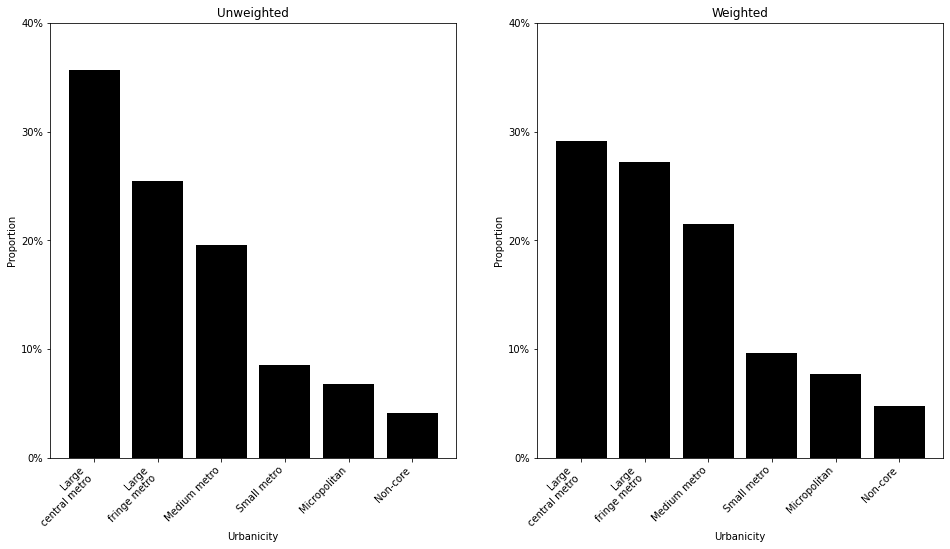

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
ax1.bar(urbanicity_histogram['urbanicity'], urbanicity_histogram['unweighted'], color="black")
ax1.set_xlabel("Urbanicity")
ax1.set_ylabel("Proportion")
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax1.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax1.set_xticklabels(["Large\ncentral metro", "Large\nfringe metro", "Medium metro", "Small metro", "Micropolitan", "Non-core"])
ax1.set_title("Unweighted")

ax2.bar(urbanicity_histogram['urbanicity'], urbanicity_histogram['weighted'], color="black")
ax2.set_xlabel("Urbanicity")
ax2.set_ylabel("Proportion")
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax2.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax2.set_title("Weighted")
ax2.set_xticklabels(["Large\ncentral metro", "Large\nfringe metro", "Medium metro", "Small metro", "Micropolitan", "Non-core"])

for label in ax1.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
for label in ax2.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
#fig.savefig("../figs/urbanicity.pdf", bbox_inches='tight')
#fig.savefig("../figs/urbanicity.png", bbox_inches='tight')

# Housing Prices

In [38]:
zillow = pd.read_csv(ZILLOW_FILE, encoding='latin-1')
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,200.000,200.000,201.000,...,1292,1291,1291,1279,1266,1261,1254,1242,1236,1238
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,156.000,157.000,157.000,...,482,484,489,495,496,490,483,479,475,472
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,359.000,359.000,359.000,...,1558,1543,1525,1504,1493,1493,1485,1474,1469,1468
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,67.000,68.000,68.000,...,114,114,114,114,114,114,113,112,113,113
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,199.000,200.000,201.000,...,529,532,535,537,534,526,518,512,508,506


In [39]:
zillow['zip'] = zillow.RegionName.astype(str).str.pad(5, 'left', '0')
df['zip'] = df['zip'].str.pad(5, 'left', '0')
zillow = zillow.loc[:, ["zip", "2019-10"]].rename({"2019-10": "sqft_price"}, axis=1)
df = df.merge(zillow, how='left', on='zip')

In [40]:
df.loc[:, ['zip', 'sqft_price']]

,zip,sqft_price
0,57642,nan
1,48642,96.000
2,75605,nan
3,35611,77.000
4,17603,123.000
...,...,...
1496428,40509,124.000
1496429,54806,nan
1496430,95020,391.000
1496431,15963,50.000


# Things I've taken out

### Tweet-weighted measures: come back to this some time later


In [41]:
from statsmodels.stats.weightstats import DescrStatsW
def weighted_describe(hist):
    """
    A somewhat lazy workaround for generating similar output to describe() for tweet-weighted demographics.
    
    `hist` is a Pandas DataFrame with two columns. The first is the relevant (numeric) values and the second is the 
    number of observations of each value. That is, the input to this function is the output of calling `value_counts()` 
    on a numeric Pandas Series.
    
    It returns a Series that is formatted like the normal output of `describe()`.
    """
    
    ws = DescrStatsW(hist.iloc[:, 0], weights=hist.iloc[:, 1], ddof=0)    
    n = hist.iloc[:, 1].sum()    
    return pd.Series([n, ws.mean, ws.std, ws.quantile(0), ws.quantile(0.25), ws.quantile(0.5), ws.quantile(0.75), ws.quantile(1)], 
                     index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                     dtype=np.float64)

The second is to ask what percentage of panel members' tweets come from members of category X:

In [42]:
tweets_per_age = df.groupby('age').agg({"num_tweets": 'sum'}).reset_index()
tweets_per_age.sort_values('num_tweets', ascending=False).head(3)

,age,num_tweets
4,20.000,114772126
5,21.000,111199380
6,22.000,101418959


In [43]:
pd.concat([df['age'].describe().rename("Members"), weighted_describe(tweets_per_age).rename("Tweets")], axis=1)

,Members,Tweets
count,1483604.000,2149617465.000
mean,38.099,36.494
std,14.582,15.099
min,16.000,16.000
25%,26.000,23.000
50%,36.000,32.000
75%,48.000,47.000
max,113.000,113.000


### Comparison to voter file

In [44]:
age_vf = pd.DataFrame(
    {-1: [17685496], 15: [6], 16: [2412], 17: [38174], 18: [661273], 19: [2418374], 20: [2666509], 21: [2812042], 22: [2939271], 23: [3346028], 24: [3489311], 25: [3632444], 26: [3724652], 27: [4026283], 28: [3959841], 29: [3924884], 30: [3972400], 31: [4021170], 32: [4070199], 33: [4024160], 34: [4028632], 35: [3982492], 36: [3955871], 37: [3976472], 38: [3856777], 39: [3735061], 40: [3789168], 41: [3628781], 42: [3622414], 43: [3674612], 44: [3662938], 45: [3771735], 46: [4056906], 47: [4241855], 48: [4094299], 49: [4015198], 50: [4029660], 51: [4052044], 52: [4186613], 53: [4401202], 54: [4447359], 55: [4462249], 56: [4502375], 57: [4495459], 58: [4436877], 59: [4387544], 60: [4391967], 61: [4272158], 62: [4137141], 63: [4073588], 64: [3906233], 65: [3788257], 66: [3630547], 67: [3467809], 68: [3419261], 69: [3358771], 70: [3467821], 71: [3059695], 72: [2504454], 73: [2467336], 74: [2512089], 75: [2409347], 76: [2090096], 77: [1935778], 78: [1802737], 79: [1746581], 80: [1619633], 81: [1516002], 82: [1443223], 83: [1349669], 84: [1232711], 85: [1217424], 86: [1148180], 87: [1185469], 88: [984438], 89: [924397], 90: [850444], 91: [764197], 92: [690974], 93: [625449], 94: [538336], 95: [467877], 96: [408706], 97: [339782], 98: [267622], 99: [220675], 100: [178402], 101: [131586], 102: [104909], 103: [83972], 104: [62365], 105: [47759], 106: [36576], 107: [25191], 108: [17806], 109: [11407], 110: [7740], 111: [5824], 112: [4457], 113: [3967], 114: [2600], 115: [2630]}
).T.reset_index()
age_vf.columns = ['Age', 'Num']
age_vf['Proportion'] = age_vf['Num'] / age_vf['Num'].sum()
age_vf

,Age,Num,Proportion
0,-1,17685496,0.069
1,15,6,0.000
2,16,2412,0.000
3,17,38174,0.000
4,18,661273,0.003
...,...,...,...
97,111,5824,0.000
98,112,4457,0.000
99,113,3967,0.000
100,114,2600,0.000


In [45]:
age_vf = age_vf.iloc[1:]
weighted_describe(age_vf)

count   240188091.000
mean           50.935
std            18.927
min            15.000
25%            35.000
50%            51.000
75%            65.000
max           115.000
dtype: float64

In [46]:
df.gender.fillna("Unknown", inplace=True)
gender_analysis = df.groupby("gender").agg({"num_tweets": ["count", "sum"]}).reset_index()
gender_analysis.columns = gender_analysis.columns.to_flat_index()
gender_analysis.columns = ["Gender", "Panel Members", "Tweets"]

pd.concat([gender_analysis['Gender'], (gender_analysis['Panel Members'] / gender_analysis['Panel Members'].sum()), (gender_analysis['Tweets'] / gender_analysis['Tweets'].sum())], axis=1)

,Gender,Panel Members,Tweets
0,Female,0.540,0.522
1,Male,0.426,0.440
2,Unknown,0.034,0.038


### Comparison to the voter file

In [47]:
gender_vf = pd.DataFrame(data={
 'Male':[131222656],
 'Female':[115770007],
 'Unknown':[10880924],
}).T.reset_index()
gender_vf.columns = ['Sex', 'Num']
gender_vf['Proportion'] = gender_vf['Num'] / gender_vf['Num'].sum()
gender_vf

,Sex,Num,Proportion
0,Male,131222656,0.509
1,Female,115770007,0.449
2,Unknown,10880924,0.042


### Comparison to the voter file

In [48]:
race_vf = pd.DataFrame(data={
 'African-American':[26086362],
 'Asian':[6326374],
 'Caucasian':[193552540],
 'Hispanic':[23214362],
 'Native American':[448959],
 'Other':[630493],
 'Uncoded':[7614497],
}).T.reset_index()
race_vf.columns = ['Race', 'Num']
race_vf['Proportion'] = race_vf['Num'] / race_vf['Num'].sum()
race_vf

,Race,Num,Proportion
0,African-American,26086362,0.101
1,Asian,6326374,0.025
2,Caucasian,193552540,0.751
3,Hispanic,23214362,0.090
4,Native American,448959,0.002
5,Other,630493,0.002
6,Uncoded,7614497,0.030


### Comparison to voter file

In [49]:
party_vf = pd.DataFrame(data={
  np.nan: [55226425],
  'Conservative': [154079],
  'Democrat': [45769191],
  'Green': [263772],
  'Independent': [1777383],
  'Libertarian': [526742],
  'No Party': [23188257],
  'Other': [1195484],
  'Republican': [33429387],
  'Unaffiliated': [96283305],
  'Unknown': [10512],
  'Working Fam': [49050],
}).T.reset_index()
party_vf.columns = ['Party', 'Num']
party_vf['Party'] = party_vf.Party.replace({'Unaffiliated': 'Unknown/Other/No Party', 'Democrat': 'Democrat', 'Republican': 'Republican', np.nan:'Unknown/Other/No Party', 'No Party': 'Unknown/Other/No Party', 'Independent': 'Unknown/Other/No Party', 'Other': 'Unknown/Other/No Party', 'Libertarian': 'Unknown/Other/No Party', 'Green': 'Unknown/Other/No Party', 'Conservative': 'Unknown/Other/No Party', 'Working Fam':'Unknown/Other/No Party', 'Unknown': 'Unknown/Other/No Party'})
party_vf = party_vf.groupby('Party').agg({'Num':'sum'}).reset_index()
party_vf['Proportion'] = party_vf['Num'] / party_vf['Num'].sum()
party_vf

,Party,Num,Proportion
0,Democrat,45769191,0.177
1,Republican,33429387,0.130
2,Unknown/Other/No Party,178675009,0.693


In [50]:
weighted_histogram(df, 'registration_status')

,registration_status,unweighted,weighted
0,1.000,1.000,1.000


In [51]:
df[df.age>65][['age', 'weight']]

,age,weight
22,69.000,1.757
31,69.000,5.782
48,73.000,0.724
49,71.000,1.037
129,67.000,3.542
...,...,...
1496323,67.000,3.991
1496364,74.000,0.724
1496381,71.000,3.544
1496393,71.000,5.782


In [52]:
weighted_histogram(df[df.state.isin(["CT", "DE", "FL", "KS", "KY", "ME", "MD", "DC", 'NE'," NM", "NY", "PA," "WY"])], 'short_party')

,short_party,unweighted,weighted
0,Democrat,0.460,0.492
1,Independent,0.251,0.207
2,Republican,0.271,0.284
3,Unknown/Other,0.017,0.018


In [53]:
df.groupby(['age_bin', 'race']).agg({"id": "count"})

id
age_bin race                    
<18     African-American      40
        Asian                  7
        Caucasian            520
        Hispanic               6
        Native American        0
        Other                  0
        Uncoded               24
18-29   African-American   41416
        Asian              10692
        Caucasian         426465
        Hispanic           32238
        Native American     1452
        Other               2572
        Uncoded            14080
30-50   African-American   50620
        Asian              12141
        Caucasian         511826
        Hispanic           25838
        Native American     1298
        Other               2003
        Uncoded            16009
50-65   African-American   14426
        Asian               3975
        Caucasian         223001
        Hispanic            7436
        Native American      394
        Other                606
        Uncoded             4943
65+     African-American    4061
        Asian               1154
        Caucasian          70577
        Hispanic            2238
        Native American      100
        Other                158
        Uncoded             1288

In [54]:
df.age_bin.cat.add_categories(["NA"]).fillna("NA").value_counts(normalize=True, dropna=False)

30-50   0.414
18-29   0.353
50-65   0.170
65+     0.053
NA      0.009
<18     0.000
Name: age_bin, dtype: float64

In [55]:
df.race.value_counts(normalize=True, dropna=False)

Caucasian          0.830
African-American   0.075
Hispanic           0.045
Uncoded            0.025
Asian              0.019
Other              0.004
Native American    0.002
Name: race, dtype: float64

In [56]:
df.gender.value_counts(normalize=True,dropna=False)

Female    0.540
Male      0.426
Unknown   0.034
Name: gender, dtype: float64

In [57]:
df.urban.value_counts(normalize=True, dropna=False)

0.000   0.884
1.000   0.108
nan     0.008
Name: urban, dtype: float64

In [58]:
df.party.value_counts(normalize=True, dropna=False)

Unaffiliated   0.461
Democrat       0.245
Republican     0.149
No Party       0.120
Independent    0.010
Other          0.007
Libertarian    0.005
Green          0.002
Conservative   0.001
Working Fam    0.000
Unknown        0.000
Name: party, dtype: float64